<h2>South Korea Covid-19 Patient Data Analysis</h2>

Based on the patient level data provided by South Korea's CDC, I have been tasked to conduct an analysis on the rapidly spreading pandemic to come up with ideas as to how best to combat Covid-19. There were many pieces of data to sort through but in general I chose to focus on where risks were of spreading the disease and which populations were most impacted in order to shape policy around prevention and protection respectively.

Below are our required modules.


In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from apikeys import mapbox_access_token

from scipy import stats

map_access = mapbox_access_token
px.set_mapbox_access_token(map_access)



Below I created a bar chart taking the data from the TimeAge csv to analyze deaths by age group. Based on what we can see, those 60 and up are at great risk of death versus the rest of the population.

In [202]:
df_TimeAge = pd.read_csv(r'Data/TimeAge.csv')

fig = px.bar(df_TimeAge, x='date', y='deceased', color='age',hover_data=['confirmed'],
             color_discrete_sequence=px.colors.qualitative.Pastel1_r,
             title="Covid-19 Deaths by Age Group")
fig.show()

In order to accurately assess what seems apparent in the chart above, I created first a function to create random samples of a given age group all of the same size. This is in order to run an ANOVA test after to make sure there is significant difference between the groups.

In [203]:
def random_sample(sample_array, iterations):
    """Takes in a sample array that represents a segment of the population and a number of iterations to generate a random sample """
    container = []
    for i in range(iterations):
        sample = np.random.choice(sample_array,size = 2000)
        container.append(sum(sample)/2000)
    return container  

Below I created sample arrays for each age group then used the above random sample function to create random samples of the same size for all of them before running an ANOVA test. 

In [204]:
zeros_array = np.concatenate((np.zeros(193),np.ones(0)),axis = None)
tens_array = np.concatenate((np.zeros(708),np.ones(0)),axis = None)
twenties_array = np.concatenate((np.zeros(3362),np.ones(0)),axis = None)
thirties_array = np.concatenate((np.zeros(1496-2),np.ones(2)),axis = None)
fourties_array = np.concatenate((np.zeros(1681-3),np.ones(3)),axis = None)
fifties_array = np.concatenate((np.zeros(2286-15),np.ones(15)),axis = None)
sixties_array = np.concatenate((np.zeros(1668-41),np.ones(41)),axis = None)
seventies_array = np.concatenate((np.zeros(850-82),np.ones(82)),axis = None)
eighties_array = np.concatenate((np.zeros(556-139),np.ones(139)),axis = None)

zeros_sample = random_sample(zeros_array, 1000)
tens_sample = random_sample(tens_array, 1000)
twenties_sample = random_sample(twenties_array, 1000)
thirties_sample = random_sample(thirties_array, 1000)
fourties_sample = random_sample(fourties_array, 1000)
fifties_sample = random_sample(fifties_array, 1000)
sixties_sample = random_sample(sixties_array, 1000)
seventies_sample = random_sample(seventies_array, 1000)
eighties_sample = random_sample(eighties_array, 1000)

f_statistic, p_value = stats.f_oneway(zeros_sample, tens_sample, twenties_sample, thirties_sample, fourties_sample, fifties_sample, sixties_sample, seventies_sample, eighties_sample)

print("F-statistic:", f_statistic)
print("P-value:", p_value)

alpha = 0.0001  # significance level

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between at least two groups.")
else:
    print("Fail to reject the null hypothesis: No significant difference between groups.")


F-statistic: 400059.65163399227
P-value: 0.0
Reject the null hypothesis: There is a significant difference between at least two groups.


We see a significan F-statistic meaning there is significant difference between groups, allowing us to reject the null hypothesis. Below I plot our samples though I left out the first three age groups for display purposes as they equal to 0 and therefore are distributed in just a straight line versus normal distributions for the other samples.

(array([  1.,  14.,  49., 133., 268., 264., 168.,  81.,  20.,   2.]),
 array([0.2135 , 0.22045, 0.2274 , 0.23435, 0.2413 , 0.24825, 0.2552 ,
        0.26215, 0.2691 , 0.27605, 0.283  ]),
 <BarContainer object of 10 artists>)

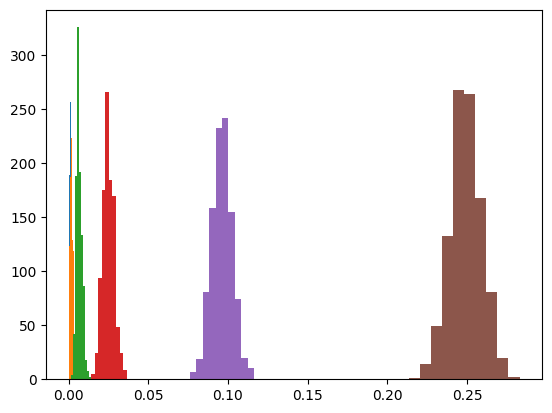

In [205]:
# plt.hist(zeros_sample)
# plt.hist(tens_sample)
# plt.hist(twenties_sample)
plt.hist(thirties_sample)
plt.hist(fourties_sample)
plt.hist(fifties_sample)
plt.hist(sixties_sample)
plt.hist(seventies_sample)
plt.hist(eighties_sample)


Below we take a look at elderly population ratio across Korea to identify where our most at risk population is located. Many of the provinces have a ratio over 20 including Gangwon-do, Gyeongsangnam-dom, Chungcheongbuk-do, and Jeollabuk-do. 

In [206]:
df_province = pd.read_csv(r'Data/Region.csv')

df_province2 = df_province.copy()
df_province2.drop(['city'], axis=1, inplace=True)

# Calculate the average values by province
region_avg_df = df_province2.groupby('province').mean()
region_avg_df.drop(['longitude', 'latitude', 'code'], axis=1, inplace=True)

long_lat_city_df = df_province.groupby('province').first()[['longitude', 'latitude', 'city']]

region_avg_df = region_avg_df.merge(long_lat_city_df, on='province')
region_avg_df = region_avg_df.drop(['elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio'], axis=1)
region_avg_df = region_avg_df.rename(
    columns={
        'elderly_population_ratio': 'Avg Elderly Population Ratio',
        'elderly_alone_ratio': 'Avg Elderly Alone Ratio',
        'nursing_home_count': 'Avg Nursing Home Count',
        'longitude': 'Longitude',
        'latitude': 'Latitude',
        'city': 'City'
    })

# Create and display the scatter map
fig = px.scatter_mapbox(region_avg_df.reset_index(), lat="Latitude", lon="Longitude", color='province', color_discrete_sequence=px.colors.qualitative.Pastel,
                         zoom=6, title="Elderly Population Ratio on Average by Province", size='Avg Elderly Population Ratio',
                         hover_data=['City', 'Avg Elderly Population Ratio', 'Avg Elderly Alone Ratio', 'Avg Nursing Home Count'],
                         labels={'province': 'Province'})
fig.update_layout(width=800)
fig.show()


Below I create a df marking the locations of significant infection cases and display the top 20 cases before creating a map with scaled circles denoting the location and severity of the spread. One outlier the Shincheonji Church was not included as it would cover up many other infection cases as within the timeframe we are analyzing it contributed to about 1/3 of all infections in South Korea.

In [207]:
df_case = pd.read_csv(r'Data/Case.csv')
group_cases_location_df = df_case[['latitude', 'longitude', 'infection_case', 'confirmed', 'province']] \
    .dropna() \
    .query("latitude != '-' and longitude != '-'") \
    .astype({'longitude': 'float', 'latitude': 'float'}) \
    .rename(columns={'province': 'Province', 'infection_case': 'Infection Case', 'latitude': 'Latitude', 'longitude': 'Longitude', 'confirmed': 'Infections'}) \
    .sort_values(by='Infections', ascending=False)

group_cases_location_df.head(20)

,Latitude,Longitude,Infection Case,Infections,Province
48,35.840080,128.566700,Shincheonji Church,4511,Daegu
49,35.857375,128.466651,Second Mi-Ju Hospital,196,Daegu
0,37.538621,126.992652,Itaewon Clubs,139,Seoul
50,35.885592,128.556649,Hansarang Convalescent Hospital,124,Daegu
1,37.482080,126.901384,Richway,119,Seoul
146,35.648870,128.736800,Cheongdo Daenam Hospital,119,Gyeongsangbuk-do
127,36.815030,127.113900,gym facility in Cheonan,103,Chungcheongnam-do
51,35.857393,128.466653,Daesil Convalescent Hospital,101,Daegu
2,37.508163,126.884387,Guro-gu Call Center,95,Seoul
147,36.927570,128.909900,Bonghwa Pureun Nursing Home,68,Gyeongsangbuk-do


In [208]:
group_cases_location_df = group_cases_location_df[group_cases_location_df.Infections < 500]
fig = px.scatter_mapbox(group_cases_location_df, lat="Latitude", lon="Longitude", 
                                color='Province',  
                                color_discrete_sequence=px.colors.qualitative.Pastel,
                                size='Infections', hover_name='Infection Case', 
                                zoom=6.5, title="COVID-19 Infections By Province")
fig.update_layout(width=800)
fig.show()

Next I chose to look at enacted policies and compared it to a timeline documenting the number of cases in South Korea. The first chunk separates out the start date of policies and their names while the second part loads the timeline and creates the chart. As the rate of infection cases starts to pick up, the South Korean government enacted a number of policies including mask sales, encouraging social distancing, and delaying school openings. The growth in number of cases seem to lessen after these efforts.

In [209]:
policy_df = pd.read_csv(r'Data/Policy.csv')
policy_df['full_policy'] = policy_df['gov_policy'] + ' ' + policy_df['detail']
policy_dates = policy_df['start_date'].tolist()
policy_labels = policy_df['full_policy'].tolist()


In [210]:
# Load your time data
time = pd.read_csv(r'Data/Time.csv')

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for the time series data
fig.add_trace(go.Scatter(x=time['date'], y=time['confirmed'], mode='lines+markers', name='Confirmed Cases'))

# Add vertical lines (bars) for policy dates
for date, label in zip(policy_dates, policy_labels):
    # Add a Scatter trace for each policy bar
    fig.add_trace(go.Scatter(
        x=[date, date],
        y=[0, max(time['confirmed'])],
        mode='lines',
        line=dict(color="red", width=2),
        name=label,
        hoverinfo='text',
        text=[label], 
        showlegend=False,  
    ))

# Configure hover behavior for the line trace
fig.update_traces(hoverinfo='x+y+name', hovertemplate='%{y} cases<br>%{x}')

# Update figure layout
fig.update_layout(
    title='COVID-19 Confirmed Cases Over Time',
    xaxis_title='Date',
    yaxis_title='Confirmed Cases',
    xaxis=dict(tickangle=45),
    showlegend=True,
    legend=dict(x=0, y=1),
    margin=dict(l=50, r=50, t=50, b=50),
    xaxis_rangeslider_visible=True,
    yaxis=dict(gridcolor='lightgray'),
)

# Show the figure
fig.show()

Lastly I decided to see if there was a difference in convalescence periods for men and women and across age groups. On average it seems that regardless of age group and sex this period is relatively similar. 

In [211]:
# Read the CSV file
df_PatientInfo = pd.read_csv('Data/PatientInfo.csv')

# Merge the DataFrames and filter rows
case_len_df = df_PatientInfo.dropna(subset=['symptom_onset_date', 'released_date'])

# Select relevant columns
case_len_df = case_len_df[['sex', 'age', 'symptom_onset_date', 'released_date']]

# Extract the decade from age
case_len_df['decade'] = case_len_df['age'].str[:1].astype(int)

# Convert date columns to datetime objects
date_columns = ['symptom_onset_date', 'released_date']

for col in date_columns:
  case_len_df[col] = pd.to_datetime(case_len_df[col], errors='coerce')

# Calculate the time durations in days
#patient_case_len_df['onset_to_confirmed'] = (patient_case_len_df['confirmed_date'] - patient_case_len_df['symptom_onset_date']).dt.days
case_len_df['onset_to_released'] = (case_len_df['released_date'] - case_len_df['symptom_onset_date']).dt.days


# Group by 'sex' and 'decade' and calculate the mean for 'onset_to_released'
case_len_df = case_len_df.groupby(['sex', 'decade'])['onset_to_released'].mean().reset_index()

# Rename the mean column for clarity
case_len_df.rename(columns={'onset_to_released': 'average_onset_to_released'}, inplace=True)

# Display the resulting DataFrame
display(case_len_df)




,sex,decade,average_onset_to_released
0,female,0,14.000000
1,female,1,54.000000
2,female,2,26.500000
3,female,3,30.190476
4,female,4,31.575758
5,female,5,33.428571
6,female,6,33.916667
7,female,7,15.000000
8,female,8,9.000000
9,male,0,30.000000


In [212]:
fig = px.histogram(case_len_df, 
                   x='decade', 
                   y='average_onset_to_released', 
                   color='sex',
                   barmode='group',  # Use 'group' for grouped bars
                   labels={'average_onset_to_released': 'Average Onset to Released', 'decade': 'Decade'},
                   title='Time from Onset to Recovery',
                   nbins=10  # Number of bins for the histogram
                   )

fig.show()

<h2>Conclusions</h2>

The elderly (those 60 and greater in age) are our most at risk population so minimizing the spread to this population is paramount.

Shutting down venues for large social gatherings is of paramount importance. Taking just the top 20 largest infection spreading events and excluding all hospitals and nursing homes from that group, there are 5266 infections; approximately 41% of all cases in South Korea stem from these venues.

Social distancing campaigns and mask sales along with delayed school openings helped curb the spread. 